In [1]:
import pickle
import pandas as pd

In [2]:
infile = open('/Users/yanlinzhang/Desktop/Natural Language Processing/Final Project/processed_final_final_df', 'rb')
final_df = pickle.load(infile)
infile.close()

In [53]:
final_df.to_csv("/Users/yanlinzhang/Desktop/Natural Language Processing/Final Project/cleaned_transcripts.csv")

## Text Preprocessing

In [54]:
# Remove special characters, spaces at the beginning and the end of the tokens, and lower-case the tokens

def clean_txt(txt_in):
    import re
    if type(txt_in) == float:
        return ''
    tmp = txt_in.strip().lower()
    tmp = re.sub("'", ' ', tmp)
    tmp = re.sub('@[A-Za-z0-9_]+', ' ', tmp)
    tmp = re.sub('#[A-Za-z0-9_]+', ' ', tmp)
    tmp = re.sub(r'http\S+', ' ', tmp)
    tmp = re.sub(r'www.\S+', ' ', tmp)
    tmp = re.sub('[()!?]', ' ', tmp)
    tmp = re.sub('\[.*?\]',' ', tmp)
    tmp = re.sub('[^a-z0-9]',' ', tmp)
    tmp = re.sub('\d+', ' ', tmp)
    return tmp

final_df['body_cleaned'] = final_df['body'].apply(lambda x: clean_txt(x))

In [272]:
# Remove stopwords

def my_stop_words(var_in):
    from nltk.corpus import stopwords
    sw = stopwords.words('english')
    sw.extend(['presentation', 'summary','year','quarter','question','time','also','today','yes','day','think',
    'growth','business','say','thanks','billion','term', 'copyright','right','reserved','operator','morning','afternoon','thank','good'])
    tmp = [word for word in var_in.split() if word not in sw]
    tmp = ' '.join(tmp)
    return tmp

final_df['body_nosw'] = final_df['body_cleaned'].apply(lambda x: my_stop_words(x))

In [273]:
# Reduce tokens to their roots

def my_stem(var_in):
    from nltk.stem.porter import PorterStemmer
    my_stem = PorterStemmer()
    tmp = [my_stem.stem(word) for word in var_in.split()]
    tmp = ' '.join(tmp)
    return tmp

def my_lemma(var_in):
    from nltk.stem  import WordNetLemmatizer
    my_lemmatizer = WordNetLemmatizer()
    tmp = [my_lemmatizer.lemmatize(word) for word in var_in.split()]
    tmp = ' '.join(tmp)
    return tmp

final_df['body_stemmed'] = final_df['body_nosw'].apply(lambda x: my_stem(x))
final_df['body_lemmatized'] = final_df['body_nosw'].apply(lambda x: my_lemma(x))

In [274]:
def remove_short(var_in):
    tmp = [word for word in var_in.split() if len(word) > 2]
    tmp = ' '.join(tmp)
    return tmp

final_df['body_lemmatized_cleaned'] = final_df['body_lemmatized'].apply(lambda x: remove_short(x))
final_df['body_stemmed_cleaned'] = final_df['body_stemmed'].apply(lambda x: remove_short(x))

In [282]:
def remove_sw(var_in):
    google_sw = ['see','continue','well','really','across','new','first','user',
                 'sync','service','new','look','see','inc','last','great','name','welcome',
                 'really','thing','one','number','market','across','going','well','going well',
                 'see','continue','well','really','across','new','google','first','user']
    tmp = [word for word in var_in.split() if word not in google_sw]
    tmp = ' '.join(tmp)
    return tmp

final_df['body_lemmatized_cleaned'] = final_df['body_lemmatized_cleaned'].apply(remove_sw)

## Mannual Topic Extraction

In [276]:
def extract_embeddings_domain(df_in, num_vec_in):

    from gensim.models import Word2Vec
    import numpy as np

    model = Word2Vec(
        df_in.str.split(), min_count=1,
        vector_size=num_vec_in, workers=3, window=5, sg=0)

    def get_score(var):
        try:
            tmp_arr = list()
            for word in var:
                tmp_arr.append(list(model.wv[word]))
        except:
            pass
        return np.mean(np.array(tmp_arr), axis=0)
        
    tmp_out = df_in.str.split().apply(get_score)
    tmp_data = tmp_out.apply(pd.Series).fillna(0)

    return tmp_data

we_matrix = extract_embeddings_domain(final_df['body_lemmatized_cleaned'], 500)

In [277]:
from gensim.models import Word2Vec

we_model = Word2Vec(
    final_df['body_lemmatized_cleaned'].str.split(), min_count=1,
    vector_size = 500, workers=3, window=5, sg=0)

In [278]:
def my_cos_sim(x_in, y_in):
    import numpy as np
    num_t = sum(x_in*y_in)
    den_t = np.linalg.norm(x_in)*np.linalg.norm(y_in)
    return num_t / den_t

topic1 = list()
topic2 = list()
topic3 = list()
topic4 = list()
topic5 = list()
topic6 = list()
topic7 = list()
topic8 = list()

for i in range(len(we_matrix)):
    topic1.append(my_cos_sim(we_matrix.loc[i, ], we_model.wv['youtube']))
    topic2.append(my_cos_sim(we_matrix.loc[i, ], we_model.wv['fiscal']))
    topic3.append(my_cos_sim(we_matrix.loc[i, ], we_model.wv['use']))
    topic4.append(my_cos_sim(we_matrix.loc[i, ], we_model.wv['revenue']))
    topic5.append(my_cos_sim(we_matrix.loc[i, ], we_model.wv['develop']))
    topic6.append(my_cos_sim(we_matrix.loc[i, ], we_model.wv['expand']))
    topic7.append(my_cos_sim(we_matrix.loc[i, ], we_model.wv['tech']))
    topic8.append(my_cos_sim(we_matrix.loc[i, ], we_model.wv['product']))


topic1_cos = pd.DataFrame(topic1).rename(columns={0: "Topic 1: Youtube"})
topic2_cos = pd.DataFrame(topic2).rename(columns={0: "Topic 2: Fiscal"})
topic3_cos = pd.DataFrame(topic3).rename(columns={0: "Topic 3: Customer"})
topic4_cos = pd.DataFrame(topic4).rename(columns={0: "Topic 4: Revenue"})
topic5_cos = pd.DataFrame(topic5).rename(columns={0: "Topic 5: Development"})
topic6_cos = pd.DataFrame(topic6).rename(columns={0: "Topic 6: Expansion"})
topic7_cos = pd.DataFrame(topic7).rename(columns={0: "Topic 7: Technology"})
topic8_cos = pd.DataFrame(topic8).rename(columns={0: "Topic 8: Product"})

showdown = topic1_cos.join(topic2_cos).join(topic3_cos).join(topic4_cos).join(topic5_cos).join(topic6_cos).join(topic7_cos).join(topic8_cos)
showdown.mean(axis = 0)

Topic 1: Youtube        0.472614
Topic 2: Fiscal         0.500026
Topic 3: Customer       0.298928
Topic 4: Revenue        0.486946
Topic 5: Development    0.464932
Topic 6: Expansion      0.514181
Topic 7: Technology     0.541809
Topic 8: Product        0.440055
dtype: float64

In [279]:
topic_assignment = showdown.idxmax(axis=1)
topic_assignment_dict = topic_assignment.to_dict()
display(topic_assignment_dict)

{0: 'Topic 2: Fiscal',
 1: 'Topic 4: Revenue',
 2: 'Topic 1: Youtube',
 3: 'Topic 7: Technology',
 4: 'Topic 7: Technology',
 5: 'Topic 4: Revenue',
 6: 'Topic 2: Fiscal',
 7: 'Topic 1: Youtube',
 8: 'Topic 2: Fiscal',
 9: 'Topic 1: Youtube',
 10: 'Topic 7: Technology',
 11: 'Topic 1: Youtube',
 12: 'Topic 7: Technology',
 13: 'Topic 4: Revenue',
 14: 'Topic 1: Youtube',
 15: 'Topic 1: Youtube',
 16: 'Topic 7: Technology',
 17: 'Topic 4: Revenue',
 18: 'Topic 7: Technology',
 19: 'Topic 2: Fiscal',
 20: 'Topic 2: Fiscal',
 21: 'Topic 2: Fiscal',
 22: 'Topic 2: Fiscal',
 23: 'Topic 4: Revenue',
 24: 'Topic 2: Fiscal',
 25: 'Topic 2: Fiscal',
 26: 'Topic 4: Revenue',
 27: 'Topic 4: Revenue',
 28: 'Topic 4: Revenue',
 29: 'Topic 2: Fiscal',
 30: 'Topic 4: Revenue',
 31: 'Topic 4: Revenue',
 32: 'Topic 4: Revenue',
 33: 'Topic 2: Fiscal',
 34: 'Topic 4: Revenue',
 35: 'Topic 4: Revenue',
 36: 'Topic 4: Revenue',
 37: 'Topic 7: Technology',
 38: 'Topic 2: Fiscal',
 39: 'Topic 2: Fiscal',
 4

In [433]:
topic_group = pd.DataFrame(topic_assignment)
topic_group['Documents'] = topic_group.index
topic_group = topic_group.groupby(0)["Documents"].apply(list).reset_index().rename(columns={0: "Topic"})
topic_group.style.set_properties(subset=['Documents'], **{'width':'400px'})

,Topic,Documents
0,Topic 1: Youtube,"[2, 7, 9, 11, 14, 15]"
1,Topic 2: Fiscal,"[0, 6, 8, 19, 20, 21, 22, 24, 25, 29, 33, 38, 39, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 74, 75, 76, 77, 114, 115, 116, 117, 118, 119, 122, 123, 124, 125, 126, 127, 128, 129, 131, 132, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168]"
2,Topic 4: Revenue,"[1, 5, 13, 17, 23, 26, 27, 28, 30, 31, 32, 34, 35, 36, 78, 120, 121, 133, 134, 135, 136, 137, 138, 139, 140, 141, 143, 147, 150]"
3,Topic 5: Development,"[169, 170, 174]"
4,Topic 6: Expansion,"[142, 144, 145, 146, 148, 149, 151, 172]"
5,Topic 7: Technology,"[3, 4, 10, 12, 16, 18, 37, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 73, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 130, 171, 173, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187]"


## LSI Model

Optimal topics is 2


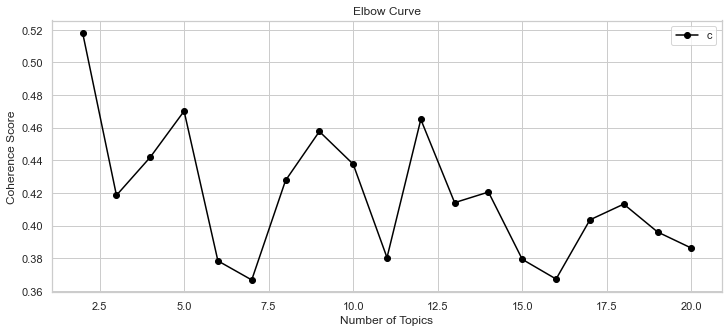

In [375]:
bi, tri = fetch_bi_grams(final_df['body_lemmatized_cleaned'].str.split())

the_data = tri

dictionary = Dictionary(the_data)
id2word = corpora.Dictionary(the_data)
    
corpus = [id2word.doc2bow(text) for text in the_data]

from gensim.models import LsiModel, TfidfModel
from gensim.similarities import MatrixSimilarity

c_scores = []
for word in range(2, 21):
    lsi_tune=  LsiModel(corpus, num_topics= word,
                                          id2word = id2word)
    coherence_tune=  CoherenceModel(model = lsi_tune, texts = the_data,
                                    dictionary = dictionary, coherence = 'c_v')
    c_scores.append(coherence_tune.get_coherence())
    
kn = KneeLocator(range(2, 21), c_scores,
                 curve= 'concave', direction = 'increasing')
opt_topics = kn.knee
print ("Optimal topics is", opt_topics)

fig=  plt.figure(figsize=  (12, 5))
plt.plot(range(2, 21), c_scores, color = 'black', marker = 'o')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.legend(('coherence_values'), loc = 'best')
plt.title('Elbow Curve')
plt.grid(True)
plt.show()

In [376]:
lsi_final=  LsiModel(corpus, num_topics= 5,
                                          id2word = id2word)
coherence_lsi=  CoherenceModel(model = lsi_final, texts = the_data,
                                    dictionary = dictionary, coherence = 'c_v')
coherence_lsi.get_coherence()

0.43898602507429996

In [426]:
topics = lsi_final.print_topics(num_words=20)
for topic in topics:
    print(topic)

(0, '-0.250*"revenue" + -0.223*"customer" + -0.178*"product" + -0.138*"margin" + -0.136*"research" + -0.134*"like" + -0.128*"next" + -0.127*"cloud" + -0.122*"would" + -0.119*"million" + -0.116*"ceo" + -0.113*"data" + -0.103*"call" + -0.103*"expect" + -0.102*"technology" + -0.101*"analyst" + -0.098*"second" + -0.094*"bit" + -0.093*"demand" + -0.092*"gross"')
(1, '-0.309*"euv" + -0.269*"asml" + 0.207*"cloud" + -0.191*"holding" + -0.178*"peter" + -0.174*"eur" + -0.173*"customer" + -0.153*"dram" + -0.137*"memory" + -0.132*"management" + -0.130*"wennink" + 0.124*"microsoft" + 0.121*"revenue" + -0.116*"board" + 0.115*"data" + 0.108*"azure" + -0.108*"tool" + 0.103*"corporation" + -0.102*"system" + -0.101*"president"')
(2, '0.232*"customer" + -0.197*"technology" + -0.170*"micron" + -0.168*"product" + 0.161*"euv" + 0.159*"microsoft" + 0.154*"cloud" + 0.150*"azure" + -0.144*"lisa" + 0.143*"asml" + 0.139*"currency" + 0.130*"constant" + -0.128*"nand" + -0.121*"micro" + -0.113*"advanced" + -0.109*"

In [378]:
tagged_corpus2 = final_df[['body','body_lemmatized_cleaned']]
tagged_corpus2['body_tokenized'] = tagged_corpus2['body_lemmatized_cleaned'].apply(lambda x: word_tokenize(x))

topic = []
for corpus in tagged_corpus2['body_tokenized']:
  topic_scores = np.array(lsi_final[id2word.doc2bow(corpus)])
  topic.append(np.argmax(topic_scores[:,1]))

tagged_corpus2["topic"] = topic

/var/folders/lp/v4x5vmys7d5506998ljns1j40000gn/T/ipykernel_54960/2189146305.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tagged_corpus2['body_tokenized'] = tagged_corpus2['body_lemmatized_cleaned'].apply(lambda x: word_tokenize(x))
/var/folders/lp/v4x5vmys7d5506998ljns1j40000gn/T/ipykernel_54960/2189146305.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tagged_corpus2["topic"] = topic


In [379]:
tagged_corpus2['topic'].value_counts()

2    80
1    53
4    36
3    19
Name: topic, dtype: int64

In [380]:
lsi_topic_group = tagged_corpus2[['topic','body']]
lsi_topic_group['body'] = lsi_topic_group.index
lsi_topic_group = lsi_topic_group.groupby('topic')["body"].apply(list).reset_index().rename(columns={'body': "Documents"})
lsi_topic_group.style.set_properties(subset=['Documents'], **{'width':'400px'})

/var/folders/lp/v4x5vmys7d5506998ljns1j40000gn/T/ipykernel_54960/1253474491.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lsi_topic_group['body'] = lsi_topic_group.index


,topic,Documents
0,1,"[6, 7, 8, 9, 10, 11, 12, 16, 18, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 119, 120, 121, 122, 123, 127, 133, 139, 141, 144, 146, 147, 153, 155, 156, 158, 159, 161, 162, 167, 168]"
1,2,"[0, 1, 2, 3, 4, 5, 13, 14, 15, 17, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 134, 135, 136, 137, 138, 140, 142, 143, 145, 148, 149, 150, 151]"
2,3,"[169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187]"
3,4,"[19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 118, 124, 125, 126, 128, 129, 130, 131, 132, 152, 154, 157, 160, 163, 164, 165, 166]"


## HDP Model

In [302]:
from gensim.models import HdpModel


hdp =  HdpModel(corpus=corpus, id2word = id2word)
coherence_hdp =  CoherenceModel(model = hdp, texts = the_data,
                                dictionary = dictionary, coherence = 'c_v')
coherence_hdp.get_coherence()


0.6394635689117046

In [429]:
topics = hdp.print_topics(num_words = 15)
for topic in topics:
    print(topic)

(0, '0.008*revenue + 0.007*cloud + 0.005*product + 0.005*data + 0.005*customer + 0.005*like + 0.004*next + 0.004*million + 0.004*margin + 0.003*research + 0.003*corporation + 0.003*microsoft + 0.003*call + 0.003*platform + 0.003*operating')
(1, '0.008*revenue + 0.008*customer + 0.006*product + 0.005*research + 0.004*like + 0.004*margin + 0.004*would + 0.004*ceo + 0.004*next + 0.004*second + 0.003*apple + 0.003*analyst + 0.003*nanometer + 0.003*call + 0.003*million')
(2, '0.008*customer + 0.007*revenue + 0.007*technology + 0.006*product + 0.006*micron + 0.005*demand + 0.005*dram + 0.005*nand + 0.005*bit + 0.004*data + 0.004*cost + 0.004*margin + 0.004*like + 0.004*cisco + 0.004*fiscal')
(3, '0.009*customer + 0.006*amazon + 0.005*revenue + 0.005*prime + 0.004*lot + 0.004*research + 0.004*would + 0.004*cloud + 0.004*next + 0.004*like + 0.003*product + 0.003*result + 0.003*brian + 0.003*call + 0.003*cfo')
(4, '0.007*product + 0.006*customer + 0.005*revenue + 0.005*technology + 0.004*like +

In [382]:
tagged_corpus3 = final_df[['body','body_lemmatized_cleaned']]
tagged_corpus3['body_tokenized'] = tagged_corpus3['body_lemmatized_cleaned'].apply(lambda x: word_tokenize(x))

topic = []
for corpus in tagged_corpus3['body_tokenized']:
  topic_scores = np.array(hdp[id2word.doc2bow(corpus)])
  topic.append(np.argmax(topic_scores[:,1]))

tagged_corpus3["topic"] = topic

/var/folders/lp/v4x5vmys7d5506998ljns1j40000gn/T/ipykernel_54960/2856077034.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tagged_corpus3['body_tokenized'] = tagged_corpus3['body_lemmatized_cleaned'].apply(lambda x: word_tokenize(x))
/var/folders/lp/v4x5vmys7d5506998ljns1j40000gn/T/ipykernel_54960/2856077034.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tagged_corpus3["topic"] = topic


In [385]:
hdp_topic_group = tagged_corpus3[['topic','body']]
hdp_topic_group['body'] = hdp_topic_group.index
hdp_topic_group = hdp_topic_group.groupby('topic')["body"].apply(list).reset_index().rename(columns={'body': "Documents"})
hdp_topic_group.style.set_properties(subset=['Documents'], **{'width':'400px'})

/var/folders/lp/v4x5vmys7d5506998ljns1j40000gn/T/ipykernel_54960/4054719455.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hdp_topic_group['body'] = hdp_topic_group.index


,topic,Documents
0,0,"[1, 4, 6, 7, 8, 10, 11, 12, 13, 14, 17, 29, 38, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 59, 63, 65, 68, 69, 70, 76, 77, 78, 80, 81, 83, 89, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 115, 125, 128, 129, 130, 131, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 157, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 184, 185, 186]"
1,1,"[0, 2, 3, 5, 9, 15, 16, 18, 22, 25, 26, 30, 35, 37, 39, 40, 58, 61, 62, 64, 67, 71, 72, 75, 79, 82, 84, 85, 86, 88, 91, 92, 93, 94, 114, 116, 122, 127, 155, 156, 158, 183, 187]"
2,2,"[19, 20, 21, 24, 27, 31, 34, 66, 73, 74, 87, 90, 118, 119, 120, 121, 123, 124, 126, 132]"
3,3,"[23, 28, 33, 36, 60, 117]"
4,4,[32]


In [430]:
hdp_topic_group1 = hdp_topic_group.replace({0: 'Microsoft product & data',
                                            1: 'Apple product R&D',
                                            2: 'Micron & Cisco fiscal ',
                                            3: 'Amazon product',
                                            4: 'Micron & Cisco product'
})


hdp_topic_group1.style.set_properties(subset=['Documents'], **{'width':'400px'})

,topic,Documents
0,Microsoft product & data,"[1, 4, 6, 7, 8, 10, 11, 12, 13, 14, 17, 29, 38, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 59, 63, 65, 68, 69, 70, 76, 77, 78, 80, 81, 83, 89, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 115, 125, 128, 129, 130, 131, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 157, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 184, 185, 186]"
1,Apple product R&D,"[0, 2, 3, 5, 9, 15, 16, 18, 22, 25, 26, 30, 35, 37, 39, 40, 58, 61, 62, 64, 67, 71, 72, 75, 79, 82, 84, 85, 86, 88, 91, 92, 93, 94, 114, 116, 122, 127, 155, 156, 158, 183, 187]"
2,Micron & Cisco fiscal,"[19, 20, 21, 24, 27, 31, 34, 66, 73, 74, 87, 90, 118, 119, 120, 121, 123, 124, 126, 132]"
3,Amazon product,"[23, 28, 33, 36, 60, 117]"
4,Micron & Cisco product,[32]


## LSI model

In [427]:
lsi_topic_group1 = lsi_topic_group.replace({0: 'product and R&D',
                                            1: 'ASML EUV + Microsoft Azure (more tech-oriented)',
                                            2: 'Micron EUV Microsoft (more product-oriented)',
                                            3: 'Micron Nvidia (more fiscal-oriented)',
                                            4: 'Microsoft Micron Nvidia commercials'
})
lsi_topic_group1.style.set_properties(subset=['Documents'], **{'width':'400px'})

,topic,Documents
0,ASML EUV + Microsoft Azure (more tech-oriented),"[6, 7, 8, 9, 10, 11, 12, 16, 18, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 119, 120, 121, 122, 123, 127, 133, 139, 141, 144, 146, 147, 153, 155, 156, 158, 159, 161, 162, 167, 168]"
1,Micron EUV Microsoft (more product-oriented),"[0, 1, 2, 3, 4, 5, 13, 14, 15, 17, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 134, 135, 136, 137, 138, 140, 142, 143, 145, 148, 149, 150, 151]"
2,Micron Nvidia (more fiscal-oriented),"[169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187]"
3,Microsoft Micron Nvidia commercials,"[19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 118, 124, 125, 126, 128, 129, 130, 131, 132, 152, 154, 157, 160, 163, 164, 165, 166]"


## LDA Model

In [146]:
def fetch_bi_grams(var):
    import numpy as np
    from gensim.models import Phrases
    from gensim.models.phrases import Phraser
    sentence_stream=  np.array(var)
    bigram=  Phrases(sentence_stream, min_count= 5, threshold= 10, delimiter= ',')
    trigram=  Phrases(bigram[sentence_stream], min_count= 5, threshold= 10)
    bigram_phraser=  Phraser(bigram)
    trigram_phraser=  Phraser(trigram)
    bi_grams = list()
    tri_grams = list()
    for sent in sentence_stream:
        bi_grams.append(bigram_phraser[sent])
        tri_grams.append(trigram_phraser[sent])
    return bi_grams, tri_grams

In [414]:
import gensim
from gensim.corpora.dictionary import Dictionary
from gensim.models.coherencemodel import CoherenceModel
import gensim.corpora as corpora
import matplotlib.pyplot as plt
from kneed import KneeLocator
    
bi, tri = fetch_bi_grams(final_df['body_lemmatized_cleaned'].str.split())

the_data = tri

dictionary = Dictionary(the_data)
id2word = corpora.Dictionary(the_data)
    
corpus = [id2word.doc2bow(text) for text in the_data]

Optimal topics is 2


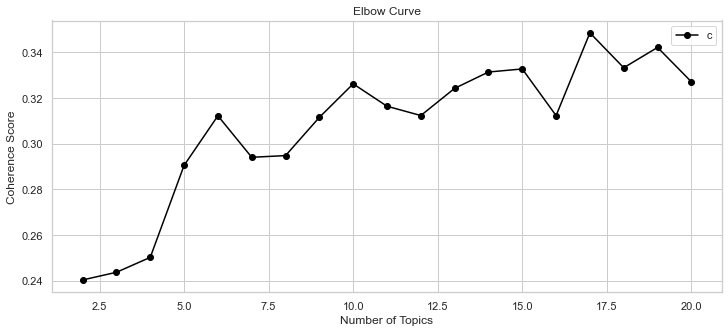

In [330]:
c_scores = []

for word in range(2, 21):
    lda_tune=  gensim.models.LdaMulticore(corpus = corpus, num_topics = word,
                                          id2word = id2word, iterations = 10, 
                                          passes = 5, random_state = 42)
    coherence_tune=  CoherenceModel(model = lda_tune, texts = the_data,
                                    dictionary = dictionary, coherence = 'c_v')
    c_scores.append(coherence_tune.get_coherence())
    
kn = KneeLocator(range(2, 21), c_scores,
                 curve= 'concave', direction = 'increasing')
opt_topics = kn.knee
print ("Optimal topics is", opt_topics)

fig=  plt.figure(figsize=  (12, 5))
plt.plot(range(2, 21), c_scores, color = 'black', marker = 'o')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.legend(('coherence_values'), loc = 'best')
plt.title('Elbow Curve')
plt.grid(True)
plt.show()

In [331]:
import gensim
import numpy as np
np.seterr(divide='ignore', invalid='ignore')

grid = {}
grid['Validation_Set'] = {}

# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')
# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')
# Validation sets

c_scores1 = []

num_of_docs = len(corpus)
corpus_sets = [# gensim.utils.ClippedCorpus(corpus, num_of_docs*0.25), 
               # gensim.utils.ClippedCorpus(corpus, num_of_docs*0.5), 
               gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.75)), 
               corpus]
corpus_title = ['75% Corpus', '100% Corpus']
model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }
for i in range(len(corpus_sets)):
            # iterate through alpha values
    for a in alpha:
                # iterare through beta values
        for b in beta:
                    lda_tune=  gensim.models.LdaMulticore(corpus = corpus, num_topics = 10,
                                          id2word = id2word, iterations = 10, 
                                          passes = 5, random_state = 42, alpha = a, eta = b)
                    coherence_tune=  CoherenceModel(model = lda_tune, texts = the_data,
                                    dictionary = dictionary, coherence = 'c_v')
                    c_scores1.append(coherence_tune.get_coherence())

                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(10)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'] = c_scores1
                    
lda_tune_result = pd.DataFrame(model_results)

In [333]:
lda_tune_result.sort_values(by= 'Coherence', ascending=False).head(20)

,Validation_Set,Topics,Alpha,Beta,Coherence
59,100% Corpus,10,asymmetric,symmetric,0.326183
54,100% Corpus,10,symmetric,symmetric,0.326183
4,75% Corpus,10,0.01,symmetric,0.326183
39,100% Corpus,10,0.31,symmetric,0.326183
34,100% Corpus,10,0.01,symmetric,0.326183
9,75% Corpus,10,0.31,symmetric,0.326183
29,75% Corpus,10,asymmetric,symmetric,0.326183
24,75% Corpus,10,symmetric,symmetric,0.326183
20,75% Corpus,10,symmetric,0.01,0.321886
55,100% Corpus,10,asymmetric,0.01,0.321886


In [415]:
lda_final =  gensim.models.LdaMulticore(corpus = corpus, num_topics = 10,
                                          id2word = id2word, iterations = 10, 
                                          passes = 5, random_state = 42,
                                          eta = 'symmetric', alpha = 0.01)
topics = lda_final.print_topics(num_words=8)
for topic in topics:
    print(topic)

(0, '0.009*"customer" + 0.008*"revenue" + 0.006*"research" + 0.005*"like" + 0.005*"ceo" + 0.004*"would" + 0.004*"next" + 0.004*"product"')
(1, '0.010*"revenue" + 0.009*"cloud" + 0.007*"customer" + 0.007*"microsoft" + 0.006*"azure" + 0.006*"currency" + 0.005*"margin" + 0.005*"data"')
(2, '0.009*"product" + 0.008*"revenue" + 0.006*"customer" + 0.006*"million" + 0.005*"data" + 0.005*"next" + 0.005*"ceo" + 0.005*"technology"')
(3, '0.014*"customer" + 0.005*"next" + 0.005*"revenue" + 0.005*"like" + 0.005*"would" + 0.005*"research" + 0.005*"demand" + 0.005*"product"')
(4, '0.010*"revenue" + 0.009*"product" + 0.006*"data" + 0.006*"million" + 0.006*"cloud" + 0.005*"customer" + 0.005*"margin" + 0.005*"like"')
(5, '0.009*"revenue" + 0.008*"customer" + 0.008*"cisco" + 0.007*"system" + 0.005*"like" + 0.005*"data" + 0.005*"product" + 0.004*"cloud"')
(6, '0.009*"customer" + 0.008*"euv" + 0.007*"would" + 0.006*"asml" + 0.006*"product" + 0.006*"revenue" + 0.006*"research" + 0.006*"margin"')
(7, '0.009

In [416]:
coherence=  CoherenceModel(model = lda_final, texts = the_data,
                                    dictionary = dictionary, coherence = 'c_v')
coherence.get_coherence()

0.32618315597217423

In [417]:
lda_final.log_perplexity(corpus)

-7.635778848059865

In [396]:
import pyLDAvis
import pyLDAvis.gensim_models
import warnings
warnings.filterwarnings('ignore', category = DeprecationWarning)

# Visualize modeling output through pyLDAvis package
pyLDAvis.enable_notebook()
visual = pyLDAvis.gensim_models.prepare(lda_final, corpus, id2word)
visual

/Users/yanlinzhang/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/yanlinzhang/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/yanlinzhang/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/yanlinzhang/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/yanlinzhang/opt/anaconda3/lib/python3.8/site-

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.009956  0.040175       1        1  16.484371
1      0.046093  0.022139       2        1  13.132472
9      0.033650 -0.014958       3        1  12.170648
6     -0.057576  0.000932       4        1  11.254539
7      0.017047 -0.034471       5        1  10.700391
8     -0.003007 -0.027548       6        1  10.699098
5      0.001789  0.013414       7        1  10.613880
4      0.009920  0.014443       8        1   7.079597
3     -0.024330 -0.007622       9        1   4.362562
0     -0.013630 -0.006503      10        1   3.502443, topic_info=          Term         Freq        Total Category  logprob  loglift
242   customer  4904.000000  4904.000000  Default  30.0000  30.0000
7030       euv  1043.000000  1043.000000  Default  29.0000  29.0000
7005      asml   882.000000   882.000000  Default  28.0000  28.0000
63       apple  1014.000000  1014.000000  Default  27.0000  27.0000
1312     cisco   980.000000   980.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
673     margin    80.197776  3025.676206  Topic10  -5.6763  -0.2787
116        bit    69.922518  2026.299531  Topic10  -5.8134  -0.0149
1793     cloud    71.652437  2849.390986  Topic10  -5.7890  -0.3313
260     demand    66.253940  1953.594120  Topic10  -5.8673  -0.0322
375     expect    65.483067  2238.203264  Topic10  -5.8790  -0.1799

[910 rows x 6 columns], token_table=       Topic      Freq   Term
term                         
1226       1  0.019255   aapl
1226       2  0.057766   aapl
1226       3  0.654679   aapl
1226       4  0.096276   aapl
1226       5  0.038511   aapl
...      ...       ...    ...
4913       7  0.029866    zen
4913       8  0.159286    zen
4913       9  0.009955    zen
4913      10  0.029866    zen
11002      2  0.679300  zukin

[4018 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 10, 7, 8, 9, 6, 5, 4, 1])

In [397]:
pyLDAvis.save_html(visual, "lda.html")

In [349]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

tagged_corpus = final_df[['body','body_lemmatized_cleaned']]
tagged_corpus['body_tokenized'] = tagged_corpus['body_lemmatized_cleaned'].apply(lambda x: word_tokenize(x))

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/yanlinzhang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/var/folders/lp/v4x5vmys7d5506998ljns1j40000gn/T/ipykernel_54960/1338983889.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tagged_corpus['body_tokenized'] = tagged_corpus['body_lemmatized_cleaned'].apply(lambda x: word_tokenize(x))


In [352]:
topic = []
for corpus in tagged_corpus['body_tokenized']:
  topic_scores = np.array(lda_final[id2word.doc2bow(corpus)])
  topic.append(np.argmax(topic_scores[:,1]))

tagged_corpus["topic"] = topic

/var/folders/lp/v4x5vmys7d5506998ljns1j40000gn/T/ipykernel_54960/4091407372.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tagged_corpus["topic"] = topic


In [369]:
lda_topic_group = tagged_corpus[['topic','body']]
lda_topic_group['body'] = lda_topic_group.index
lda_topic_group = lda_topic_group.groupby('topic')["body"].apply(list).reset_index().rename(columns={'body': "Documents"})
lda_topic_group.style.set_properties(subset=['Documents'], **{'width':'400px'})

/var/folders/lp/v4x5vmys7d5506998ljns1j40000gn/T/ipykernel_54960/3007140218.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lda_topic_group['body'] = lda_topic_group.index


,topic,Documents
0,0,"[9, 139, 145, 147]"
1,1,"[14, 25, 133, 134, 135, 136, 137, 138, 140, 141, 142, 143, 144, 146, 148, 149, 150, 151, 171, 180]"
2,2,"[6, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 44, 57, 58, 59, 61, 63, 67, 68, 70, 71, 72, 74, 108, 115, 116, 117, 118, 119, 120, 121, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 165, 166, 167, 170, 172, 173, 176, 178, 179]"
3,3,"[13, 42, 43, 45, 47, 48, 49, 51, 60, 62, 64, 65, 66, 69, 73, 75, 79, 81, 83, 88, 103, 105, 106, 174]"
4,4,"[1, 12, 15, 41, 50, 52, 53, 55, 76, 78, 80, 82, 84, 85, 86, 87, 89, 90, 92, 95, 97, 98, 99, 100, 101, 102, 104, 109, 110, 112, 114, 122, 123, 125, 169, 182]"
5,5,"[3, 8, 10, 11, 17, 46, 77, 91, 93, 94, 96, 107, 113, 177, 185, 186]"
6,6,"[0, 2, 4, 7, 18, 54, 111, 124, 126, 127, 128]"
7,7,"[5, 56, 175, 187]"
8,8,"[16, 129, 130, 131, 132, 164, 168, 181]"
9,9,"[183, 184]"


In [412]:
lda_topic_group1 = lda_topic_group.replace({0: 'Microsoft product & tech',
                                            1: 'Microsoft cloud computing',
                                            2: 'Apple product & tech',
                                            3: 'ASML EUV (more revenue-oriented)',
                                            4: 'Amazon product & tech',
                                            5: 'Cisco software and products',
                                            6: 'Tech center (cisco)',
                                            7: 'Cloud, tech, software',
                                            8: 'ASML EUV (more customer-oriented)',
                                            9: 'ASML EUV (more research-oriented)'
})
lda_topic_group1.style.set_properties(subset=['Documents'], **{'width':'400px'})

,topic,Documents
0,Microsoft product & tech,"[9, 139, 145, 147]"
1,Microsoft cloud computing,"[14, 25, 133, 134, 135, 136, 137, 138, 140, 141, 142, 143, 144, 146, 148, 149, 150, 151, 171, 180]"
2,Apple product & tech,"[6, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 44, 57, 58, 59, 61, 63, 67, 68, 70, 71, 72, 74, 108, 115, 116, 117, 118, 119, 120, 121, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 165, 166, 167, 170, 172, 173, 176, 178, 179]"
3,ASML EUV (more revenue-oriented),"[13, 42, 43, 45, 47, 48, 49, 51, 60, 62, 64, 65, 66, 69, 73, 75, 79, 81, 83, 88, 103, 105, 106, 174]"
4,Amazon product & tech,"[1, 12, 15, 41, 50, 52, 53, 55, 76, 78, 80, 82, 84, 85, 86, 87, 89, 90, 92, 95, 97, 98, 99, 100, 101, 102, 104, 109, 110, 112, 114, 122, 123, 125, 169, 182]"
5,Cisco software and products,"[3, 8, 10, 11, 17, 46, 77, 91, 93, 94, 96, 107, 113, 177, 185, 186]"
6,Tech center (cisco),"[0, 2, 4, 7, 18, 54, 111, 124, 126, 127, 128]"
7,"Cloud, tech, software","[5, 56, 175, 187]"
8,ASML EUV (more customer-oriented),"[16, 129, 130, 131, 132, 164, 168, 181]"
9,ASML EUV (more research-oriented),"[183, 184]"


## Ensemble LDA

In [399]:
from gensim.models import EnsembleLda

elda = EnsembleLda(topic_model_class='ldamulticore', corpus = corpus, id2word = id2word, num_topics = 20, num_models = 5)

topics = elda.print_topics(num_words=8)
for topic in topics:
    print(topic)

    coherence=  CoherenceModel(model = elda , texts = the_data,
                                    dictionary = dictionary, coherence = 'c_v')
coherence.get_coherence()

(0, '0.008*"revenue" + 0.007*"customer" + 0.006*"product" + 0.005*"like" + 0.005*"research" + 0.004*"margin" + 0.004*"next" + 0.004*"cloud"')


0.21949191875562168

In [420]:
topics = elda.print_topics(num_words=20)
for topic in topics:
    print(topic)

(0, '0.008*"revenue" + 0.007*"customer" + 0.006*"product" + 0.005*"like" + 0.005*"research" + 0.004*"margin" + 0.004*"next" + 0.004*"cloud" + 0.004*"would" + 0.004*"million" + 0.004*"data" + 0.004*"ceo" + 0.003*"call" + 0.003*"analyst" + 0.003*"expect" + 0.003*"second" + 0.003*"technology" + 0.003*"result" + 0.003*"bit" + 0.003*"strong"')


In [418]:
elda.log_perplexity(corpus)

-7.675541414479138

In [400]:
tagged_corpus4 = final_df[['body','body_lemmatized_cleaned']]
tagged_corpus4['body_tokenized'] = tagged_corpus4['body_lemmatized_cleaned'].apply(lambda x: word_tokenize(x))

topic = []
for corpus in tagged_corpus4['body_tokenized']:
  topic_scores = np.array(elda[id2word.doc2bow(corpus)])
  topic.append(np.argmax(topic_scores[:,1]))

tagged_corpus4["topic"] = topic

/var/folders/lp/v4x5vmys7d5506998ljns1j40000gn/T/ipykernel_54960/93119132.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tagged_corpus4['body_tokenized'] = tagged_corpus4['body_lemmatized_cleaned'].apply(lambda x: word_tokenize(x))
/var/folders/lp/v4x5vmys7d5506998ljns1j40000gn/T/ipykernel_54960/93119132.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tagged_corpus4["topic"] = topic


In [405]:
elda_topic_group = tagged_corpus4[['topic','body']]
elda_topic_group['body'] = elda_topic_group.index
elda_topic_group = elda_topic_group.groupby('topic')["body"].apply(list).reset_index().rename(columns={'body': "Documents"})
elda_topic_group.style.set_properties(subset=['Documents'], **{'width':'400px'})

/var/folders/lp/v4x5vmys7d5506998ljns1j40000gn/T/ipykernel_54960/2523909080.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  elda_topic_group['body'] = elda_topic_group.index


,topic,Documents
0,0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187]"


In [425]:
elda_topic_group1 = elda_topic_group.replace({0: 'customer, product, revenue, research, etc'})
elda_topic_group1.style.set_properties(subset=['Documents'], **{'width':'400px'})

,topic,Documents
0,"customer, product, revenue, research, etc","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187]"


In [437]:
compare = {'Algorithm': ["Manual","LDA", "Ensemble LDA", "LSI", "HDP"],
           'Coherence score': ['None',0.3262,0.2195,0.4390,0.6394],
           'K specification required': ['Yes','Yes','No','Yes','No'],
           'Topics generated': [8, 10, 1, 5, 20],
           'Topics assigned': [6, 10, 1, 4, 5]}

pd.DataFrame.from_dict(compare)

,Algorithm,Coherence score,K specification required,Topics generated,Topics assigned
0,Manual,None,Yes,8,6
1,LDA,0.3262,Yes,10,10
2,Ensemble LDA,0.2195,No,1,1
3,LSI,0.439,Yes,5,4
4,HDP,0.6394,No,20,5
